# 3_Building footprints classification

Notebook for the 3rd pipeline - building footprints classification. In this notebook, we would like to test the 4-step process:
1. Generate additional features for clustering (rectangularity, polygon turning functions, proximity matrix)
1. Apply Tobler's geography law into clustering footprints (objects that are closed together --> same functions | near things are more relevant than far things)
    1. Proximity-based grouping footprints into building blocks (DBSCAN)
    1. Geography law apply: find footprints with similar shape (turning func, rectangularity) + size (total_area) ==> get majority of types
        1. Same building block
        1. Same area
    1. Apply statistical analysis results to categorize left-over footprints

## Initialization

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

d:\programdata\anaconda3\envs\phoenix\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [2]:
import pandas as pd
import numpy as np
import sys
import os
import glob
import re

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
%matplotlib inline

# from shapely import wkt
# from shapely.geometry import box, Polygon
# from geopandas import GeoDataFrame
# import hdbscan

In [3]:
# Self-made modules
import helpers as hp
import buildings_classification as bc

In [4]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## Inputs
Define inputs path

In [5]:
buildings_int_path = '../data/02_intermediate/buildings_data/'
buildings_pri_path = '../data/03_primary/buildings_data/'

plz_ags_csv = '../data/01_raw/zuordnung_plz_ort_landkreis.csv'

# Demographics
ags_living_csv = '../data/01_raw/de_living_2019.csv'
ags_population_csv = '../data/01_raw/de_population_2019.csv'

# Community directory dataframe
GV_path = '../data/01_raw/GV/GV100AD_301120.asc'


Demographics data

In [6]:
ags_living = pd.read_csv(ags_living_csv, 
                         sep = ';', 
                         encoding = 'cp1250', 
                         dtype= {'1_Auspraegung_Code':str},
                         low_memory = False)
ags_population = pd.read_csv(ags_population_csv, 
                             sep = ';', 
                             dtype= {'1_Auspraegung_Code':str},
                             encoding = 'cp1250', 
                             low_memory = False)


Geographic data

In [7]:
# Contain local AGS codes (no regional)
plz_ags = pd.read_csv(plz_ags_csv, dtype= {'plz': str, 'ags': str})
plz_ags.shape

(12883, 4)



## Building blocks segmentation with (H)DBSCAN

In the paper ["Proximity-based grouping of buildings in urban blocks"](https://www.researchgate.net/publication/271901065_Proximity-based_grouping_of_buildings_in_urban_blocks_A_comparison_of_four_algorithms), the authors used 2 different approaches to evaluate 4 algorithms in clustering buildings into urban blocks. It concludes that DBSCAN (Density-based spatial clustering of applications with noise) together with ASCDT (An adaptive spatial clustering algorithm based on delaunay triangulation) performed best and their degree of complexity is not hard to implement. Thus, in this project, I implemented HDBSCAN - an extended version of DBSCAN to cluster our OSM building footprints.

### Reason not to use K-means (bonus)

When think of clustering, k-means usually pops right up as the first answer. As the algorithm itself, k-means is designed to minimize variance. 

Since the data is in latitude, longitude format ==> not **linear**, worst case is k-means will never converge (even with Haversine distance). To circumvent this problem, we should use an algorithm that can handle arbitrary distance functions, in particular geodetic distance functions such as Hierarchical clustering, PAM, CLARA, OPTICS and DBSCAN.

(inspired from [*])

### HDBSCAN
HDBSCAN is a clustering algorithm developed by Campello, Moulavi, and Sander[*]. It extends DBSCAN by converting it into a hierarchical clustering algorithm, and then using a technique to extract a flat clustering based in the stability of clusters. Since clusters formed are not radius-based, they can be in non-circular format. Hence, it is more suitable for geo-analytics considering footprints boundaries are not in circular shape.And this is the algorithm we will use to group building footprints together.

Another good read to understand HDBSCAN better from [Author Name]'s article is here https://towardsdatascience.com/understanding-hdbscan-and-density-based-clustering-121dbee1320e


#### Parameters

More details on the official page [HERE](!https://hdbscan.readthedocs.io/en/latest/parameter_selection.html)


For our project, we need to generate a **proximity matrix** for all building footprints in the area. Since we have already gathered and cleaned building objects data from ~10k municipalities in Germany (refer to the previous article), it is better to keep the building blocks grouping it the same granularity level (a.k.a municipality-level - AGS key)

There are 3 parameters for HDBSCAN we need to set:
*Epsilon* (ε)
*MinPts* 


We will start with the baseline from the paper with *ε* = 3 and *MinPts* = 2 then fine-tune them to get optimized values

> If “MinPts (minimum points)” = 2, any 2 or more points within the ε distance away from each other will be considered a cluster.





### References
[*] Ester, M. (2019). A density-based algorithm for discovering clusters in large spatial databases with noise. [online] Psu.edu. Available at: https://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.121.9220 [Accessed 2 Jan. 2021].

[*] McInnes, L., Healy, J. and Astels, S. (2017). hdbscan: Hierarchical density based clustering. [online] ResearchGate. Available at: https://www.researchgate.net/publication/315508524_hdbscan_Hierarchical_density_based_clustering [Accessed 6 Jan. 2021].

[*] Clustering geo location coordinates (lat,long pairs (2014). Clustering geo location coordinates (lat,long pairs). [online] Data Science Stack Exchange. Available at: https://datascience.stackexchange.com/questions/761/clustering-geo-location-coordinates-lat-long-pairs [Accessed 6 Jan. 2021].



### Group AGS into Landkreis (1 level up)

Currently AGS key (8-digit) is structured as follow:

![AGS definition](../docs/3_AGS_definition.png)




In [8]:
plz_ags['ags_district'] = plz_ags['ags'].apply(lambda x: hp._left(x,5))
# Group to get only district-level ==> ~ 400 districts
plz_ags_dist = plz_ags.groupby('ags_district').size().to_frame('count').reset_index()
plz_ags_dist.shape

(401, 2)

In [9]:
plz_ags_dist.sort_values('count', ascending = False).head(10)

,ags_district,count
155,07232,236
152,07143,193
324,11000,190
10,01058,178
345,13071,153
349,13075,148
350,13076,147
6,01054,141
151,07141,139
11,01059,137


In [41]:
for dist_id in plz_ags_dist.ags_district:
    print(dist_id)

01001
01002
01003
01004
01051
01053
01054
01055
01056
01057
01058
01059
01060
01061
01062
02000
03101
03102
03103
03151
03153
03154
03155
03157
03158
03159
03241
03251
03252
03254
03255
03256
03257
03351
03352
03353
03354
03355
03356
03357
03358
03359
03360
03361
03401
03402
03403
03404
03405
03451
03452
03453
03454
03455
03456
03457
03458
03459
03460
03461
03462
04011
04012
05111
05112
05113
05114
05116
05117
05119
05120
05122
05124
05154
05158
05162
05166
05170
05314
05315
05316
05334
05358
05362
05366
05370
05374
05378
05382
05512
05513
05515
05554
05558
05562
05566
05570
05711
05754
05758
05762
05766
05770
05774
05911
05913
05914
05915
05916
05954
05958
05962
05966
05970
05974
05978
06411
06412
06413
06414
06431
06432
06433
06434
06435
06436
06437
06438
06439
06440
06531
06532
06533
06534
06535
06611
06631
06632
06633
06634
06635
06636
07111
07131
07132
07133
07134
07135
07137
07138
07140
07141
07143
07211
07231
07232
07233
07235
07311
07312
07313
07314
07315
07316
07317
07318
0731

In [45]:
# test case for 1 district
dist_id = '01058'

plz_ags[plz_ags.ags_district == dist_id].shape

(178, 5)

In [46]:
dist_df = bc.generate_dist_data(dist_id, buildings_pri_path)
dist_df.shape

(95536, 19)

## Generate features for building footprints

Datasets are already generated from pipeline... no need to run here. Just take directly from 03_primary


Shape + Size

In [13]:
# df_geo.geometry.iloc[1].area

In [14]:
# bc.shape_size(df_geo.geometry.iloc[1])[0]

### HDBSCAN for grouping building blocks

In [15]:
# Drop unnecessary column
dist_df.drop(columns = ['Unnamed: 0'], errors = 'ignore', inplace = True)

#### TEMP #####
dist_df.rename(columns = {'postcode':'ags'}, errors = 'ignore', inplace = True)

In [16]:
# Perform on district-level dataframe
buildings_clust_df = bc.hdbscan_bld(dist_df,
                                    min_cluster_size=8,
                                    # follow the paper suggestion baseline
                                    cluster_selection_epsilon=0.0003, # 3 meters
                                    min_samples=2)

2021-01-12 23:22:43,333 - root - INFO - Generate total of 670 building blocks in the area.


In [42]:
buildings_clust_df.columns

Index(['type', 'id', 'nodes', 'center.lat', 'center.lon', 'tags.building',
       'building_levels', 'tags.source', 'tags.addr:city',
       'tags.addr:housenumber', 'ags', 'tags.addr:street', 'tags.addr:suburb',
       'geometry', 'timestamp', 'building_types', 'surface_area',
       'rectangularity', 'total_area', 'building_block'],
      dtype='object')

In [17]:
bc.generate_stats_table(buildings_clust_df)

,building_types,count,mean_rectangularity,mean_surface_area,sd_surface_area,sd_rectangularity
0,accessory_storage,1284,128.750106,0.600825,0.140784,157.695186
1,accessory_supply,109,475.720768,0.536388,0.127230,786.860125
2,commercial,148,686.027402,0.539243,0.142476,1428.134359
3,industrial,139,1520.505451,0.585736,0.184354,2941.718600
4,other,40,447.029459,0.655780,0.126475,705.393958
5,public,252,638.251351,0.548922,0.155476,870.668680
6,residential,6381,175.748415,0.631479,0.137382,113.883824
7,to_be_classified,29434,229.697737,0.591466,0.141463,410.607095


### Construct machine learning models to classify footprints into types

Creating training dataset using features:
- Rectangularity
- Surface area
- Building block (from HDBSCAN result)

Target variable is **building_types** from naive classification

In [18]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline

# List of algorithms want to test
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier

In [19]:
# Turn into a binary classification problem: residentials vs the rest
df = buildings_clust_df[buildings_clust_df.building_types != 'to_be_classified'][['building_types', # target variable
                                                                                  'rectangularity',
                                                                                  'surface_area',
                                                                                  'building_block']]

df['building_types'] = np.where(df.building_types != 'residential', 'non-residential','residential')

# Quick correlation check
df[['rectangularity','surface_area']].corr()

,rectangularity,surface_area
rectangularity,1.000000,-0.096967
surface_area,-0.096967,1.000000


In [20]:
# Extra
bc.generate_stats_table(buildings_clust_df)

,building_types,count,mean_rectangularity,mean_surface_area,sd_surface_area,sd_rectangularity
0,accessory_storage,1284,128.750106,0.600825,0.140784,157.695186
1,accessory_supply,109,475.720768,0.536388,0.127230,786.860125
2,commercial,148,686.027402,0.539243,0.142476,1428.134359
3,industrial,139,1520.505451,0.585736,0.184354,2941.718600
4,other,40,447.029459,0.655780,0.126475,705.393958
5,public,252,638.251351,0.548922,0.155476,870.668680
6,residential,6381,175.748415,0.631479,0.137382,113.883824
7,to_be_classified,29434,229.697737,0.591466,0.141463,410.607095


In [21]:
# Factorize features & target variable
bld_definition = pd.factorize(df['building_types'])[1]
df.building_types = pd.factorize(df['building_types'])[0]

df.building_block = pd.factorize(df['building_block'])[0]

bld_definition

Index(['non-residential', 'residential'], dtype='object')

In [22]:
#Splitting the data into independent and dependent variables
X = df[['rectangularity',
       'surface_area',
       'building_block',
       ]].values

y = df[['building_types']].values

# Using Skicit-learn to split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [23]:
clfs = []
seed = 42

clfs.append(("LogReg", 
             Pipeline([("Scaler", StandardScaler()),
                       ("LogReg", LogisticRegression())])))
clfs.append(("XGBClassifier",
             Pipeline([("Scaler", StandardScaler()),
                       ("XGB", XGBClassifier())]))) 
clfs.append(("KNN", 
             Pipeline([("Scaler", StandardScaler()),
                       ("KNN", KNeighborsClassifier())]))) 

clfs.append(("DecisionTreeClassifier", 
             Pipeline([("Scaler", StandardScaler()),
                       ("DecisionTrees", DecisionTreeClassifier())]))) 

clfs.append(("RandomForestClassifier", 
             Pipeline([("Scaler", StandardScaler()),
                       ("RandomForest", RandomForestClassifier())]))) 

clfs.append(("RidgeClassifier", 
             Pipeline([("Scaler", StandardScaler()),
                       ("RidgeClassifier", RidgeClassifier())])))

clfs.append(("BaggingRidgeClassifier",
             Pipeline([("Scaler", StandardScaler()),
                       ("BaggingClassifier", BaggingClassifier())])))

clfs.append(("ExtraTreesClassifier",
             Pipeline([("Scaler", StandardScaler()),
                       ("ExtraTrees", ExtraTreesClassifier())])))   

In [24]:
# Iterate to get best model
results, names  = [], [] 
n_folds = 10
scoring = 'accuracy'
for name, model  in clfs:
    kfold = KFold(n_splits=n_folds, random_state=seed, shuffle = True)
    cv_results = cross_val_score(model, X_train, y_train, cv= 10, scoring=scoring, n_jobs=-1)*100    
    names.append(name)
    results.append(cv_results)    

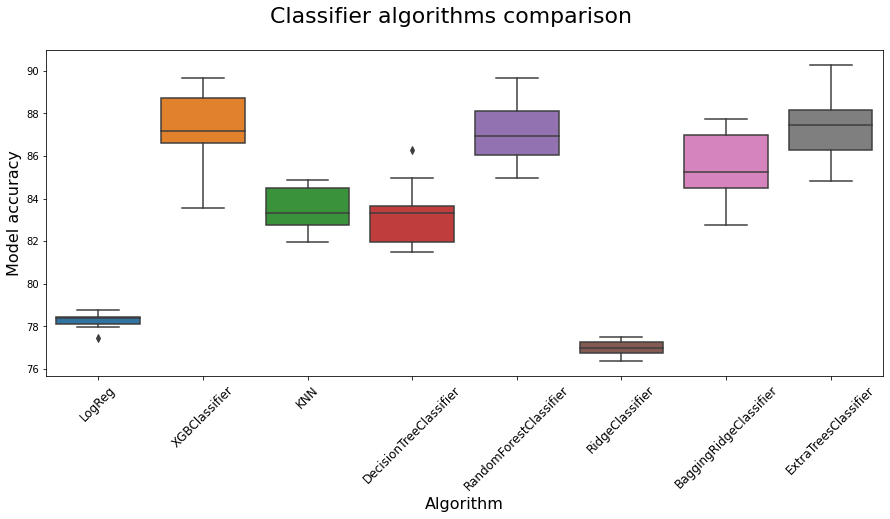

In [25]:
# boxplot algorithm comparison
fig = plt.figure(figsize=(15,6))
fig.suptitle('Classifier algorithms comparison', fontsize=22)
ax = fig.add_subplot(111)
sns.boxplot(data = results)
ax.set_xticklabels(names)
ax.set_xlabel("Algorithm", fontsize=16)
ax.set_ylabel("Model accuracy", fontsize=16)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45, fontsize = 12)
plt.show()

In [26]:
clfs[1]

('XGBClassifier',
 Pipeline(steps=[('Scaler', StandardScaler()),
                 ('XGB',
                  XGBClassifier(base_score=None, booster=None,
                                colsample_bylevel=None, colsample_bynode=None,
                                colsample_bytree=None, gamma=None, gpu_id=None,
                                importance_type='gain',
                                interaction_constraints=None, learning_rate=None,
                                max_delta_step=None, max_depth=None,
                                min_child_weight=None, missing=nan,
                                monotone_constraints=None, n_estimators=100,
                                n_jobs=None, num_parallel_tree=None,
                                random_state=None, reg_alpha=None,
                                reg_lambda=None, scale_pos_weight=None,
                                subsample=None, tree_method=None,
                                validate_parameters=None, verb

In [27]:
classifier = XGBClassifier(random_state = 42)

In [28]:
# Get result from CV steps and apply 
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(f'Accuracy: %.3f (%.3f) {accuracy_score(y_test, y_pred)}')

d:\programdata\anaconda3\envs\phoenix\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
d:\programdata\anaconda3\envs\phoenix\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[23:22:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[ 326  175]
 [  95 1493]]
              precision    recall  f1-score   support

           0       0.77      0.65      0.71       501
           1       0.90      0.94      0.92      1588

    accuracy                           0.87      2089
   macro avg       0.83      0.80      0.81      2089
weighted avg       0.87      0.87      0.87      2089

Accuracy: %.3f (%.3f) 0.8707515557683102


### Apply best model on "to_be_classifed" footprints in the area

In [29]:
classify_df = buildings_clust_df[buildings_clust_df.building_types == 'to_be_classified']

# Apply scaling
classify_scaled = scaler.transform(classify_df[['rectangularity','surface_area','building_block']])

yhat = classifier.predict(classify_scaled)
pd.DataFrame(yhat).value_counts()

1    22135
0     7299
dtype: int64

In [30]:
buildings_clust_df.building_block.value_counts().head()

-1     2440
289    1519
231    1216
9       615
121     541
Name: building_block, dtype: int64

In [31]:
# Generate building block dataset for visualization (BEFORE)
block_id = '121'
buildings_block_b4_df = buildings_clust_df[buildings_clust_df.building_block == block_id]
buildings_block_b4_df.building_types.value_counts()

accessory_storage    220
to_be_classified     172
residential          122
accessory_supply       9
commercial             8
industrial             5
public                 4
other                  1
Name: building_types, dtype: int64

In [32]:
# Before
buildings_clust_df['building_types'].value_counts()

to_be_classified     29434
residential           6381
accessory_storage     1284
public                 252
commercial             148
industrial             139
accessory_supply       109
other                   40
Name: building_types, dtype: int64

In [33]:
classify_df = classify_df.assign(building_types_pred = yhat)[['id','building_types_pred']]
# Only take those classified as "residential"
classify_df = classify_df[classify_df.building_types_pred == 1]

# Get list of OSM_ID 
residential_list = list(classify_df.id)
buildings_clust_df['building_types'] = np.where(buildings_clust_df.id.isin(residential_list), 'residential', buildings_clust_df.building_types)

In [34]:
# After
buildings_clust_df['building_types'].value_counts()

residential          28516
to_be_classified      7299
accessory_storage     1284
public                 252
commercial             148
industrial             139
accessory_supply       109
other                   40
Name: building_types, dtype: int64

#### Plot example block in the area

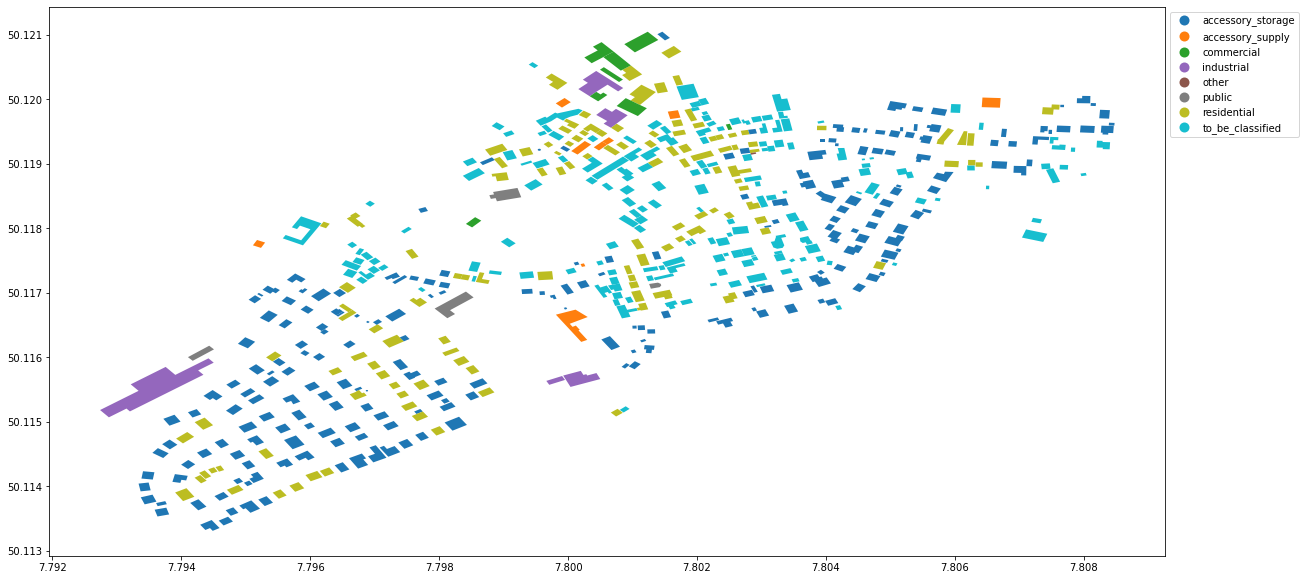

In [35]:
# BEFORE
bc.plot_buildings_area(buildings_block_b4_df, 
                       plot_type = 'building_types',
                       legend_ncol = 1)

In [36]:
# Get example
buildings_block_df = buildings_clust_df[buildings_clust_df.building_block == block_id]
buildings_block_df.building_types.value_counts()

residential          247
accessory_storage    220
to_be_classified      47
accessory_supply       9
commercial             8
industrial             5
public                 4
other                  1
Name: building_types, dtype: int64

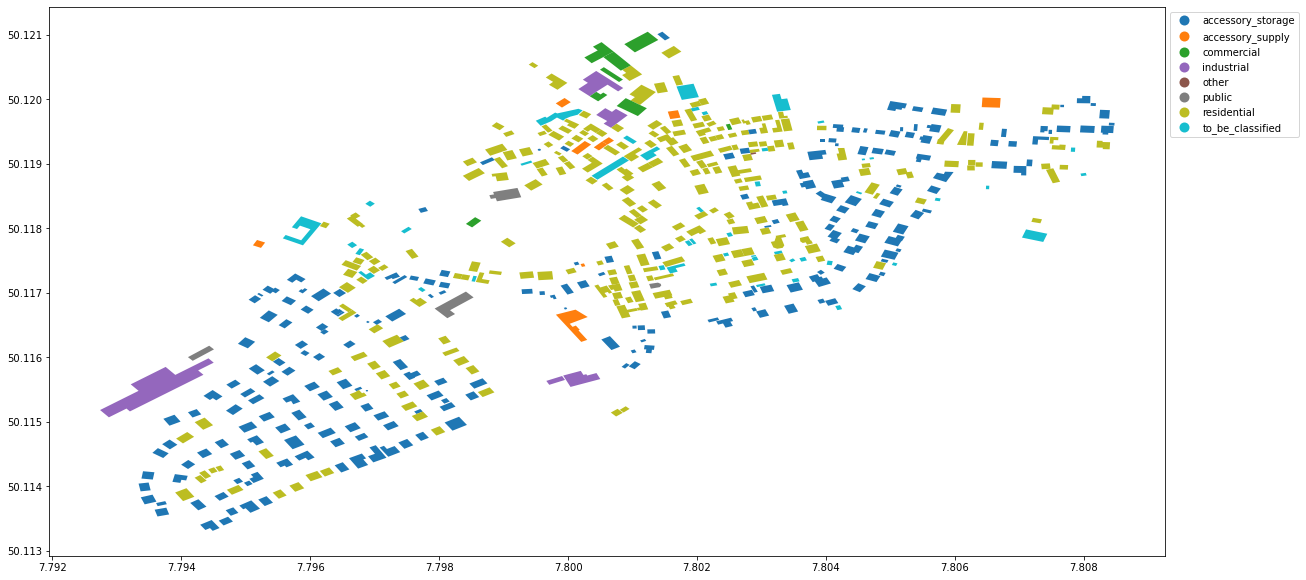

In [37]:
bc.plot_buildings_area(buildings_block_df, 
                       plot_type = 'building_types',
                       legend_ncol = 1)

In [38]:
bc.generate_stats_table(buildings_block_df)

,building_types,count,mean_rectangularity,mean_surface_area,sd_surface_area,sd_rectangularity
0,accessory_storage,220,150.703233,0.591873,0.131875,83.572419
1,accessory_supply,9,265.180900,0.560241,0.157174,262.596639
2,commercial,8,407.710356,0.456230,0.080789,252.002856
3,industrial,5,1459.616320,0.443229,0.093379,1507.966042
4,other,1,20.184300,0.580254,0.000000,0.000000
5,public,4,485.175413,0.495140,0.153599,288.339042
6,residential,247,161.108108,0.571183,0.111678,77.298744
7,to_be_classified,47,129.274578,0.574577,0.138595,196.439392


# DEV

## Plot naive vs hdbscan result (1 AGS for Medium article example only)

In [39]:
# Plot settings
plt.rcParams['axes.facecolor'] = 'white'

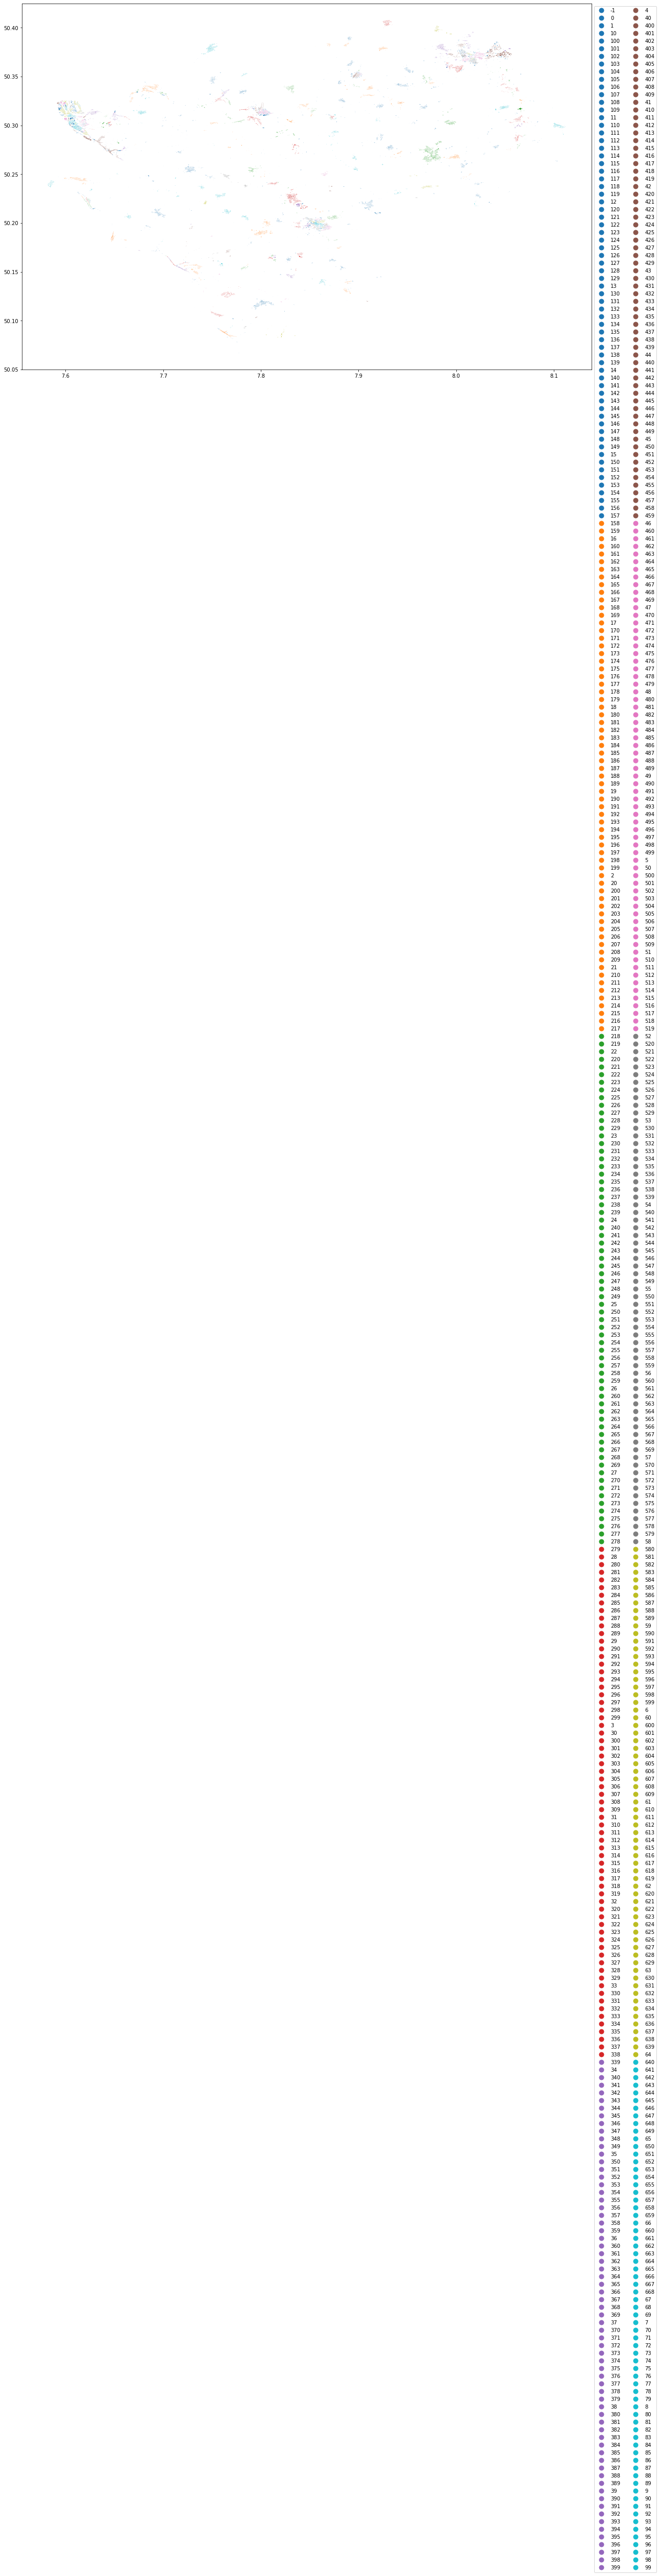

In [40]:
# bc.plot_buildings_area(buildings_clust_df, 
#                        plot_type = 'building_block',
#                        legend_ncol = 2)